loading data

In [16]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scipy
import os
import os.path as osp
from sklearn.metrics import adjusted_rand_score

In [17]:
# for loading DLPFC12 data
def load_DLPFC(root_dir='/Users/zhuyuling/Downloads/DLPFC12', section_id='151507'):
    # 151507, ..., 151676 
    # 12 in total, 7 layers
    # 151507: n_obs × n_vars = 4221 × 33538
    ad = sc.read_visium(path=os.path.join(root_dir, section_id), count_file=section_id+'_filtered_feature_bc_matrix.h5')
    ad.var_names_make_unique()

    gt_dir = os.path.join(root_dir, section_id, 'gt')
    gt_df = pd.read_csv(os.path.join(gt_dir, 'tissue_positions_list_GTs.txt'), sep=',', header=None, index_col=0)
    ad.obs['original_clusters'] = gt_df.loc[:, 6]
    keep_bcs = ad.obs.dropna().index
    ad = ad[keep_bcs].copy()
    ad.obs['original_clusters'] = ad.obs['original_clusters'].astype(int).astype(str)
    print("spot num", ad)
    return ad

# for loading mHypothalamus data
# already preprocessed? Xs are floats
def load_mHypothalamus(root_dir='/Users/zhuyuling/Desktop/Dataset/mHypothalamus', section_id='0.26'):
    # section id = '0.26', '0.21', '0.16', '0.11', '0.06', '0.01', '-0.04', '-0.09', '-0.14', '-0.19', '-0.24', '-0.29' 12 in total
    # cluster =     15      15      14      15      15      15      14       15       15       15      16        15
    # 9 clusters: ['BST' 'MPA' 'MPN' 'PV' 'PVH' 'PVT' 'V3' 'fx'] n_obs × n_vars = 5488 × 155
    info_file = os.path.join(root_dir, 'MERFISH_Animal1_info.xlsx')
    cnts_file = os.path.join(root_dir, 'MERFISH_Animal1_cnts.xlsx')
    xls_cnts = pd.ExcelFile(cnts_file)
    # print(xls_cnts.sheet_names)
    df_cnts = pd.read_excel(xls_cnts, section_id)
    
    xls_info = pd.ExcelFile(info_file)
    df_info = pd.read_excel(xls_info, section_id)
    # print(df_cnts, df_info)
    spatial_X = df_info.to_numpy()
    obs_ = df_info
    if len(df_info.columns) == 5:
        obs_.columns = ['psuedo_barcodes', 'x', 'y', 'original_clusters', 'Neuron_cluster_ID']
    elif len(df_info.columns) == 6:
        obs_.columns = ['psuedo_barcodes', 'x', 'y', 'cell_types', 'Neuron_cluster_ID', 'original_clusters']
    obs_.index = obs_['psuedo_barcodes'].tolist()
    # print(obs_)

    var_ = df_cnts.iloc[:, 0]
    var_ = pd.DataFrame(var_)
    # print(var_)
    
    ad = anndata.AnnData(X=df_cnts.iloc[:,1:].T, obs=obs_, var=var_)
    spatial = np.vstack((ad.obs['x'].to_numpy(), ad.obs['y'].to_numpy()))
    ad.obsm['spatial'] = spatial.T
    return ad
################fei added: layers of mHypothalamus: ['BST', 'MPA', 'MPN', 'PV', 'PVH', 'PVT', 'V3', 'fx']

In [19]:
import scanpy as sc
section_ids_list=['151508', '151509', '151510']
data_1=load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id='151507')
meta_data_1=data_1.obsm['spatial'] 
median_1=np.median(meta_data_1,axis=0)
#
result=pd.DataFrame(meta_data_1)
result=result.set_index(data_1.obs_names)
result = result.rename(columns={0: 'X', 1: 'Y'})
result['original_clusters']=data_1.obs['original_clusters']
result['slice']='151507'
#result['X']=data_1.obs_names
ds=pd.DataFrame()
ds = pd.concat([ds,result],axis=0)
for index,s in enumerate(section_ids_list):
    data_2=load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id=s)
    meta_data_2=data_2.obsm['spatial'] 
    
    median_2=np.median(meta_data_2,axis=0)
    result=meta_data_2-median_2+median_1
    result=pd.DataFrame(result)
    result=result.set_index(data_2.obs_names)
    result = result.rename(columns={0: 'X', 1: 'Y'})
    result['original_clusters']=data_2.obs['original_clusters']
    result['slice']=s
    #result['X']=data_2.obs_names
    ds = pd.concat([ds,result],axis=0)
 
ds.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151507_151510_coord.csv')

/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4381 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4788 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
spot num AnnData object with n_obs × n_vars = 4595 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
import pandas as pd
import pickle as pkl
from sklearn.metrics.pairwise import euclidean_distances
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151507_151510_coord.csv')
 
section_ids_list=['151507','151508', '151509', '151510']

for index in range(len(section_ids_list)-1):
    slice_1= df_1.loc[df_1['slice']==int(section_ids_list[index]),['X','Y']]
    slice_2=df_1.loc[df_1['slice']==int(section_ids_list[index+1]),['X','Y']]
    alignment=euclidean_distances(slice_1,slice_2)
    alignment = np.exp(-alignment)
    dataset=str(section_ids_list[index])+'_'+str(section_ids_list[index+1])
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment_res/DLPFC4', dataset, dataset+'_AlignmentPi.pkl')
    if not os.path.exists(osp.join('/Users/zhuyuling/Desktop/Dataset/alignment_res/DLPFC4', dataset)):
        os.makedirs(osp.join('/Users/zhuyuling/Desktop/Dataset/alignment_res/DLPFC4', dataset))
    with open(map_path,'wb') as f:
        pkl.dump(alignment, f)

In [14]:
def cal_layer_based_alignment_result(alignment, s1, s2):
    #fei added
    labels = []
    labels.extend(s1.obs['original_clusters'])
    labels.extend(s2.obs['original_clusters'])

    res = []
    l_dict = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6}
    cnt0 = 0
    cnt1 = 0
    cnt2 = 0
    cnt3 = 0
    cnt4 = 0
    cnt5 = 0
    cnt6 = 0
    for i, elem in enumerate(alignment):
        if np.max(elem) - np.min(elem) != 0: # paste2 might have spots that are not aligned to any other spots. paste might have negative alignment
            if labels[i] == '-1' or labels[elem.argmax() + alignment.shape[0]] == '-1':
                continue
            if l_dict[labels[i]] == l_dict[labels[elem.argmax() + alignment.shape[0]]]:
                cnt0 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 1:
                cnt1 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 2:
                cnt2 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 3:
                cnt3 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 4:
                cnt4 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 5:
                cnt5 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 6:
                cnt6 += 1
    res.extend([cnt0, cnt1, cnt2, cnt3, cnt4, cnt5, cnt6])
    return res
def cal_paste_paste2_lba(dataset, s1, s2):
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment_res/DLPFC4', dataset, dataset+'_AlignmentPi.pkl')
    #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    #map_path = osp.join(input, method_path, file_name +'_'+dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pkl.load(f)
    
    lba = cal_layer_based_alignment_result(ali_o, s1, s2)
    sub_lba = [element/s1.shape[0] for element in lba]  
    return sub_lba
slices=  ['151507','151508', '151509', '151510']
#df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151669_151672_coord.csv')
 
df=pd.DataFrame()
for index in range(0,len(slices)-1):
    slice1= load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id=slices[index]) 
    slice2 =  load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id=slices[index+1])
    dataset=str(slices[index])+'_'+str(slices[index+1])
    laa=cal_paste_paste2_lba(dataset,slice1,slice2)
    df2=pd.DataFrame({
        dataset:laa
        })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
print(df)
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151507_151510_LAA.csv')

/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4381 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4381 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4788 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4788 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4595 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
   151507_151508  151508_151509  151509_151510
0       0.857380       0.194933       0.853175
1       0.099029       0.443278       0.135547
2       0.000237       0.324355       0.000000
3       0.000000       0.000000       0.000000
4       0.000000       0.000000       0.000000
5       0.000000       0.001141       0.000000
6       0.043355       0.036293       0.011278


In [15]:
def compute_alignment_ari(sliceA, sliceB, pi):
    mapped_clusters = []
    for j in range(pi.shape[1]):
        mapping = pi[:, j]
        #original: if np.sum(mapping) > 0:
        if np.max(mapping) - np.min(mapping) != 0:
            i = np.argmax(mapping)
            mapped_clusters.append(sliceA.obs['original_clusters'][i])
        else:
            mapped_clusters.append("NULL")
    assert len(sliceB.obs['original_clusters']) == len(mapped_clusters)
    true_clusters_mapped_region = []
    mapped_clusters_mapped_region = []
    for i in range(len(sliceB.obs['original_clusters'])):
        if mapped_clusters[i] != "NULL":
            true_clusters_mapped_region.append(sliceB.obs['original_clusters'][i])
            mapped_clusters_mapped_region.append(mapped_clusters[i])

    ari = adjusted_rand_score(true_clusters_mapped_region, mapped_clusters_mapped_region)
    return ari

def cal_paste_paste2_ari(dataset,s1,s2):
    sub_ari=[]
        #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment_res/DLPFC4', dataset, dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pkl.load(f)
         
    arI = compute_alignment_ari(s1, s2, ali_o)
    sub_ari.append(arI)
    return sub_ari
slices=['151507','151508', '151509', '151510']
#df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151669_151672_coord.csv')
 
df=pd.DataFrame()
for index in range(0,len(slices)-1):
    slice1= load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id=slices[index])  
    slice2 =  load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id=slices[index+1])
    dataset=str(slices[index])+'_'+str(slices[index+1])
    laa=cal_paste_paste2_ari(dataset,slice1,slice2)
    df2=pd.DataFrame({
        dataset:laa
        })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
print(df)
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151507_151510_ARI.csv')

/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4381 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4381 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4788 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4788 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


spot num AnnData object with n_obs × n_vars = 4595 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
   151507_151508  151508_151509  151509_151510
0       0.786379       0.186886       0.730484


/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_14081/1303518874.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding['Z'] = index
/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_14081/1303518874.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip([0,1,2,3,4,5,6],cmap)))
/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_14081/1303518874.py:15: SettingWithCopyWarning: 
A value is trying to

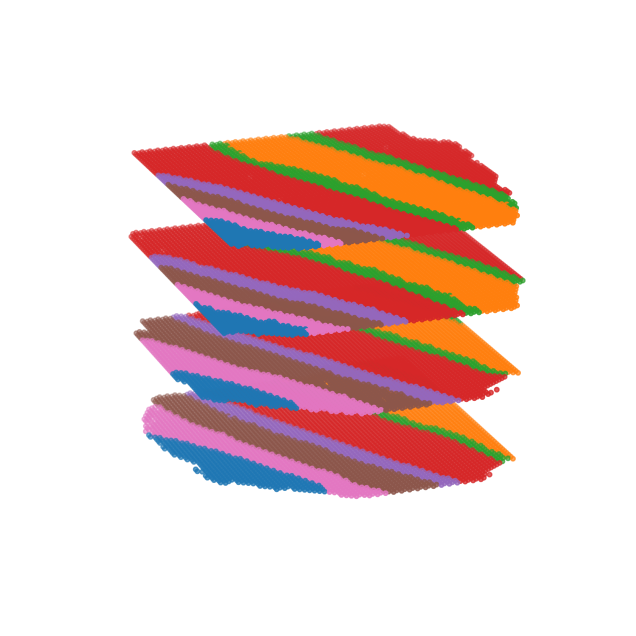

In [12]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from SPACEL import Scube
import os
cmap = []
for e in plt.get_cmap('tab10').colors:
    cmap.append(matplotlib.colors.rgb2hex(e))
coo = pd.DataFrame()
slice_id=['151507','151508', '151509', '151510']
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151507_151510_coord.csv',index_col=0)
 
for index, i in enumerate(slice_id):
    embedding=df_1.loc[df_1['slice'] == int(i),]
    embedding['Z'] = index
    embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip([0,1,2,3,4,5,6],cmap)))
    
    coo = pd.concat([coo,embedding],axis=0)
 
coo = coo[['X', 'Y','Z','original_clusters','celltype_colors','slice']]
coords=coo.values[:,:3]
'''
coo['X'], coo['Z'] = coo['Z'], coo['X']
coo['X'], coo['Y'] = coo['Y'], coo['X']
coo['Z'] = -coo['Z']
print(coords)
#coords = coo.values[:,:3]
'''
coo.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/Scube_outputs/scHolography_DLPFC_151507_151510_aligned_coordinates_colors.csv')
'''
coords[:,[2, 0]] = coords[:,[0, 2]]
coords[:,[1, 0]] = coords[:,[0, 1]]
coords[:, 2] = -coords[:, 2]
'''
#2. save fig
fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=20, azim=160, frameon=False, show=True, s=10, return_fig=True) # Scube is from SPACEL

fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4', "scHolography_gtAndScube_DLPFC_151507_151510_3dviz_angle20_160_1122_24.pdf"), bbox_inches="tight")


alignment results:
1. save alignment matrix in .pkl file
2. calculate LAA & Ari and save in .csv file

alignment pairs:
for DLPFC: align the adjacent slices in the same samples e.g. 151507 and 151508, 151508 and 151509, etc
for mHypothalamus: align the adjacent slices: -0.04 and -0.09, -0.09 and -0.14, -0.14 and -0.19, -0.19 and -0.24
for simuData: align 151673 to each of the simData: e.g., 151673 and 100%, 151573 and 80%, ...
            align 151673 with 100%, 100% with 80%, 80% with 60%, 60% with 40%, 40% with 20% (the alignment results of this one is used to do 3D)

3D
1. save other info. e.g., coor., cluster no,... in .csv file
2. save fig in .pdf file
3. save rotation degree, total distance, and distance per spot (this is for simulated data only) in .csv file